# Task 02 : Lens Finding
Task: Build a model identifying lenses using PyTorch or Keras. For the training use the images in train_lenses and train_nonlenses directories, for evaluation use the images from test_lenses and test_nonlenses directories. Note that the number of non-lenses is much larger than the number of lensed galaxies. Pick the most appropriate approach and discuss your strategy.


## Breakdown to approach: 
* Handling Class Imbalance Properly, The dataset has far more non-lens images than lens images. I am using data augmentation, supporting sampling techniques, allowing for weighted loss functions.
* Faster convergence as there is effecinet data loading.
* Using CNN for feature extraction, using a pre trained model for fine tuning can save time and results better.
* It also aligns with project's expectation, (Increase the number of known strong lenses. and Insight into properties of the identified lens candidates.) 



In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
import numpy as np
import os
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt


In [2]:
class LensDataset(Dataset):
    def __init__(self, lens_dir, non_lens_dir, transform=None):
        self.lens_images = [os.path.join(lens_dir, f) for f in os.listdir(lens_dir) if f.endswith('.npy')]
        self.non_lens_images = [os.path.join(non_lens_dir, f) for f in os.listdir(non_lens_dir) if f.endswith('.npy')]

        self.images = self.lens_images + self.non_lens_images
        self.labels = [1] * len(self.lens_images) + [0] * len(self.non_lens_images)
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        img = np.load(img_path)  # Shape (3, 64, 64)
        img = torch.tensor(img, dtype=torch.float32)

        if self.transform:
            img = self.transform(img)

        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return img, label


In [3]:
# Data transformations
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
])

In [6]:
# Directories
train_lens_dir = "/kaggle/input/lens-finding-test/test_lenses"
train_non_lens_dir = "/kaggle/input/lens-finding-test/train_nonlenses"
test_lens_dir = "/kaggle/input/lens-finding-test/test_lenses"
test_non_lens_dir = "/kaggle/input/lens-finding-test/test_nonlenses"

In [7]:
# Create datasets and data loaders
train_dataset = LensDataset(train_lens_dir, train_non_lens_dir, transform=transform)
test_dataset = LensDataset(test_lens_dir, test_non_lens_dir)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [17]:
define_model_path = "/kaggle/input/resnet/resnet18-f37072fd.pth"
model = models.resnet18()
model.load_state_dict(torch.load(define_model_path, map_location=torch.device('cpu')))


<ipython-input-17-ce3f5f0b557d>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(define_model_path, map_location=torch.device('cpu')))


<All keys matched successfully>

Checking DataLoader...
Batch Shape: torch.Size([32, 3, 64, 64]) Labels Shape: torch.Size([32])
Training Samples: 28870
Testing Samples: 19650
Manual Forward Pass Output Shape: torch.Size([32])
Starting Training...
Training on: cpu
Batch 0, Loss: 0.8366
Batch 10, Loss: 0.0288
Batch 20, Loss: 0.3112
Batch 30, Loss: 0.0026
Batch 40, Loss: 0.0054
Batch 50, Loss: 0.4523
Batch 60, Loss: 0.0086
Batch 70, Loss: 0.0082
Batch 80, Loss: 0.0024
Batch 90, Loss: 0.0021
Batch 100, Loss: 0.1862
Batch 110, Loss: 0.0209
Batch 120, Loss: 0.0101
Batch 130, Loss: 0.0065
Batch 140, Loss: 0.0023
Batch 150, Loss: 0.0055
Batch 160, Loss: 0.0032
Batch 170, Loss: 0.0060
Batch 180, Loss: 0.2455
Batch 190, Loss: 0.0151
Batch 200, Loss: 0.1133
Batch 210, Loss: 0.0170
Batch 220, Loss: 0.0136
Batch 230, Loss: 0.0053
Batch 240, Loss: 0.0092
Batch 250, Loss: 0.0032
Batch 260, Loss: 0.0134
Batch 270, Loss: 0.2348
Batch 280, Loss: 0.0046
Batch 290, Loss: 0.1211
Batch 300, Loss: 0.0061
Batch 310, Loss: 0.0044
Batch 320, L

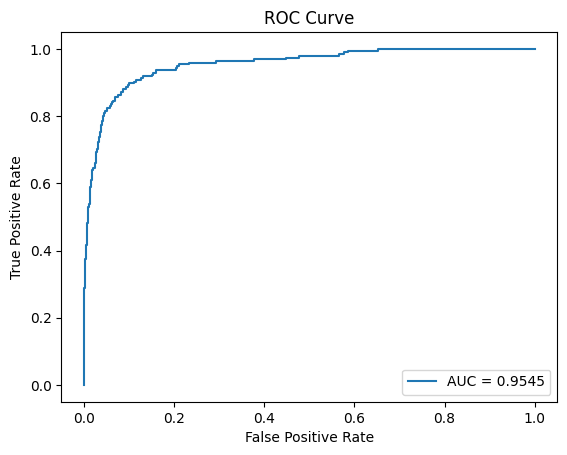

AUC Score: 0.9545


In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

define_model_path = "/kaggle/input/resnet/resnet18-f37072fd.pth"
model = models.resnet18()
model.load_state_dict(torch.load(define_model_path, map_location=device, weights_only=True))
model.fc = nn.Linear(model.fc.in_features, 1)  # Adjust for binary classification
model = model.to(device)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Debug: Check if data is loading
print("Checking DataLoader...")
for images, labels in train_loader:
    print("Batch Shape:", images.shape, "Labels Shape:", labels.shape)
    break

print(f"Training Samples: {len(train_loader.dataset)}")
print(f"Testing Samples: {len(test_loader.dataset)}")

# Debug: Check manual forward pass
images, labels = next(iter(train_loader))
images, labels = images.to(device), labels.to(device)
outputs = model(images).view(-1)
print("Manual Forward Pass Output Shape:", outputs.shape)

def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    print("Starting Training...")
    print(f"Training on: {device}")
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images).view(-1)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
            if i % 10 == 0:  # Print every 10 batches
                print(f"Batch {i}, Loss: {loss.item():.4f}")
        
        print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {running_loss/len(train_loader):.4f}")
    print("Training Completed!")

def evaluate_model(model, test_loader): # Evaluation using AUC and ROC curve
    print("Starting Evaluation...")
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).view(-1)
            probs = torch.sigmoid(outputs)
            all_preds.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    auc_score = roc_auc_score(all_labels, all_preds)
    fpr, tpr, _ = roc_curve(all_labels, all_preds)

    plt.figure()
    plt.plot(fpr, tpr, label=f'AUC = {auc_score:.4f}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.title('ROC Curve')
    plt.show()

    print(f"AUC Score: {auc_score:.4f}")

# Run training and evaluation
train_model(model, train_loader, criterion, optimizer, num_epochs=10)
evaluate_model(model, test_loader)


In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")